In [1]:
import os
import re
import pickle
import torch
import deepspeed
import jsonlines

from typing import List, Optional, Tuple, Union

import sys
sys.path.append("/lid/home/saydalie/multimodal_cot")
sys.path.append("/lid/home/saydalie/multimodal_cot/anole")

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from transformers import ChameleonForCausalLM, ChameleonProcessor, GenerationConfig

from training.constants_training import (
    ANOLE_PATH_HF,
    ANOLE_PATH_HF_TRAINED,
    DATASET_TOKENIZED_DIR,
    DATASET_RAW_DIR
)

[2025-03-17 10:01:16,209] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.6
 [WARNING]  using untested triton version (3.2.0), only 1.0.0 is known to be compatible


/home/saydalie/.local/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:49: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
/home/saydalie/.local/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:67: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOpe

In [2]:
def extract_final_answer(text: str) -> str:
    # Normalize spaces and remove excessive newlines
    text = re.sub(r"\s+", " ", text).strip()

    # Define patterns to capture various answer formats
    patterns = [
        r"answer\s*is[:\-]?\s*\(?([A-D])\)?",     # Standard: "answer is: (A)" or "answer is A"
        r"final\s*answer[:\-]?\s*\(?([A-D])\)?",   # "Final answer: A" or "Final answer (A)"
        r"correct\s*(?:option|choice|answer)[:\-]?\s*\(?([A-D])\)?",  # "Correct choice: A"
    ]

    # Try matching each pattern
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1)

    return None

# Define the dataset class
class TokenizedDataset(Dataset):
    def __init__(self, data_dir, pattern_names, start_idx=0, end_idx=9999):
        self.tokenized_data = []

        for pattern_name in pattern_names:
            data_file_path = os.path.join(data_dir, f"{pattern_name}.jsonl")

            with jsonlines.open(data_file_path) as reader:
                for idx, obj in enumerate(reader):
                    if (idx < start_idx) or (idx > end_idx):
                        continue

                    self.tokenized_data.append(torch.tensor(obj['input_text_ids'], dtype=torch.long))
    
    def __len__(self):
        return len(self.tokenized_data)
    
    def __getitem__(self, idx):
        return self.tokenized_data[idx]

# Define custom collate function
def collate_fn(batch):
    # pad_id = 1
    # left padding
    batch_flipped = [item.flip(0) for item in batch]
    batch_inputs_padded = pad_sequence(batch_flipped, batch_first=True, padding_value=1).flip(1)
    
    # Create attention mask
    attention_mask = torch.zeros_like(batch_inputs_padded, dtype=torch.long)
    attention_mask = attention_mask.masked_fill(batch_inputs_padded != 1, 1)

    return {'input_ids': batch_inputs_padded, 'attention_mask': attention_mask}

def split_token_sequence(
    tokens: torch.LongTensor,
    boi: int,
    eoi: int
) -> List[Tuple[str, torch.LongTensor]]:
    """
    Split a sequence of tokens into text and image segments.
    
    Args:
        tokens (torch.LongTensor): The token sequence.
        boi (int): Begin of image token.
        eoi (int): End of image token.
    
    Returns:
        List[Tuple[str, torch.LongTensor]]: List of tuples indicating segment type and tokens.
    """
    batch_size, _ = tokens.shape
    assert batch_size == 1, "Batch size must be 1"
    
    device = tokens.device
    tokens = tokens[0]  # remove batch dimension
    tokens = tokens.to(device)
    segments = []
    current_segment = []
    in_image_seg = False

    for token in tokens:
        if token == boi:
            # if entering an image segment, save the current text segment (if any)
            if current_segment:
                segments.append(("text_seg", torch.tensor(current_segment, dtype=tokens.dtype, device=device).reshape(1, -1)))
                current_segment = []
            in_image_seg = True
        elif token == eoi and in_image_seg:
            # if exiting an image segment, save the current image segment
            segments.append(("image_seg", torch.tensor(current_segment, dtype=tokens.dtype, device=device).reshape(1, -1)))
            current_segment = []
            in_image_seg = False
        else:
            current_segment.append(token)
    # save any remaining tokens
    if current_segment:
        if in_image_seg:
            segments.append(("image_seg", torch.tensor(current_segment, dtype=tokens.dtype, device=device).reshape(1, -1)))
        else:
            segments.append(("text_seg", torch.tensor(current_segment, dtype=tokens.dtype, device=device).reshape(1, -1)))
    return segments

# Inference

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# pattern_names = ["circle_size_number", "color_number_hexagon", "grid_number", "polygon_sides_number", "shape_morph", "shape_size_hexagon", "triangle", 'color_grid', 'color_overlap_squares', 'grid_number_color', 'rectangle_height_color', 'shape_reflect', "size_cycle", 'venn', 'color_hexagon', 'color_size_circle', 'polygon_sides_color', 'rectangle_height_number', 'shape_size_grid', "size_grid"]
pattern_names = ['color_number_hexagon']
model_path = "Anole-7B-5DS-CE/checkpoint-15620"

In [5]:
model = ChameleonForCausalLM.from_pretrained(
    ANOLE_PATH_HF_TRAINED / model_path,
    torch_dtype=torch.bfloat16
)
model.to(device)
model.eval()

processor = ChameleonProcessor.from_pretrained(ANOLE_PATH_HF)

Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.43it/s]


In [18]:
for pattern_name in pattern_names:
    eval_dataset = TokenizedDataset(
        data_dir=os.path.join(DATASET_TOKENIZED_DIR, "eval"),
        pattern_names=[pattern_name]
    )

    eval_dataloader = DataLoader(
        dataset=eval_dataset,
        batch_size=16,
        collate_fn=collate_fn,
        shuffle=False
    )
    break

In [19]:
for item in eval_dataloader:
    break

In [20]:
item

{'input_ids': tensor([[16386, 33411, 16409,  ..., 46937, 16409, 16582],
         [16386, 33411, 16409,  ..., 46937, 16409, 16582],
         [16386, 33411, 16409,  ..., 46937, 16409, 16582],
         ...,
         [16386, 33411, 16409,  ..., 46937, 16409, 16582],
         [16386, 33411, 16409,  ..., 46937, 16409, 16582],
         [16386, 33411, 16409,  ..., 46937, 16409, 16582]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]])}

In [21]:
with torch.no_grad():
    generate_ids = model.generate(
        input_ids = item['input_ids'].to(device),
        attention_mask = item['attention_mask'].to(device),
        max_length = 6144,
        do_sample=False,
        # temperature=1.0,
        pad_token_id=1
    )
print(generate_ids.shape)
print(generate_ids)

torch.Size([16, 5624])
tensor([[16386, 33411, 16409,  ..., 16392, 16397,     2],
        [16386, 33411, 16409,  ..., 16392, 16397,     2],
        [16386, 33411, 16409,  ..., 16392, 16397,     2],
        ...,
        [16386, 33411, 16409,  ...,     1,     1,     1],
        [16386, 33411, 16409,  ...,     1,     1,     1],
        [16386, 33411, 16409,  ..., 16392, 16397,     2]], device='cuda:0')


In [28]:
# decodes only text
outputs = []
batch_outputs = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

for batch_output in batch_outputs:
    outputs.append({'pattern_name': pattern_name, 'output': batch_output, 'final_answer': extract_final_answer(batch_output)})

In [ ]:
processor = ChameleonProcessor.from_pretrained(ANOLE_PATH_HF)

In [92]:
prompt = """# Question:
<image>{question}

# Options:
{options}

# Pattern
"""

In [96]:
map_option_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}

question = "What is the color of the missing part denoted with a question mark?"
options = ["red", "purple", "blue", "yellow"]

images = [
    Image.open('/lid/home/saydalie/multimodal_cot/LLM-PuzzleTest/PuzzleVQA/data/train/images/color_grid/color_grid_9999.png')
]

prompts = [
    prompt.format(
        question=question,
        options='\n'.join([f"({map_option_to_letter[option_idx]}) {option}" for option_idx, option in enumerate(options)])
    )
]

inputs = processor(images=images, text=prompts, padding=True, return_tensors="pt").to(device="cuda", dtype=torch.bfloat16)

In [100]:
print(inputs['input_ids'].shape)
inputs['input_ids']

torch.Size([1, 1076])


tensor([[    0, 16386, 33411,  ..., 46937, 16582,  8710]], device='cuda:0')

In [133]:
# Replaces all the image tokens with a single token: Soo weird
inputs['input_ids'][0, :50]

tensor([16386, 33411, 16409, 16582,  8197,  8711,  8711,  8711,  8711,  8711,
         8711,  8711,  8711,  8711,  8711,  8711,  8711,  8711,  8711,  8711,
         8711,  8711,  8711,  8711,  8711,  8711,  8711,  8711,  8711,  8711,
         8711,  8711,  8711,  8711,  8711,  8711,  8711,  8711,  8711,  8711,
         8711,  8711,  8711,  8711,  8711,  8711,  8711,  8711,  8711,  8711],
       device='cuda:0')

In [118]:
# remove 0 and 8710
inputs['input_ids'] = inputs['input_ids'][:, 1:-1]
inputs['attention_mask'] = inputs['attention_mask'][:, 1:-1]

In [119]:
# Generate
generate_ids = model.generate(
    **inputs,
    max_new_tokens=6144
)
output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [120]:
print(output[0])

# Question:
What is the color of the missing part denoted with a question mark?

# Options:
(A) red
(B) purple
(C) blue
(D) yellow

# Pattern
There are circles with different colors arranged with a grid formation in the image. The colors in the first row are ['purple', 'red', 'purple'], the colors in the second row are ['red', 'blue', 'red'], and the colors in the third row are ['purple', '?', 'purple']. We observe that the circles at the corners are purple, while the circles directly adjacent to the center are red. Only the center circle is blue. Hence, the pattern is that the circles alternate in color depending on if they are at the corner or adjacent to the center.

# Option A
Replacing '?' with red: 
Reasoning: Comparing the colors of the circles at the corners and adjacent to the center, it matches well the observed pattern. red is a strong candidate for the correct answer.

# Option B
Replacing '?' with purple: 
Reasoning: Comparing the colors of the circles at the corners and a

In [122]:
extract_final_answer(output[0])

'A'

#### Decode with HF: only text

In [22]:
# decodes only text
output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
print(output[0])

# Question:
What is the missing number of the part denoted with a question mark?

# Options:
(A) 4
(B) 9
(C) 2
(D) 1

# Pattern:
There is a hexagon split into six parts with the colors ['purple', 'red', 'orange', 'purple', 'orange', 'red'] in an anti-clockwise order. The parts are denoted with the numbers [3, 1, '?', 1, 9, 7] respectively. We observe that the numbers in the orange parts add up to 10. Similarly, the numbers in the purple parts also add up to 10. Thus, the pattern is that the numbers in the parts of the same color add up to 10.

# Option A
Replacing '?' with 4: 
Reasoning: Comparing the sum of the numbers of the parts with the same color, it does not fit the observed pattern. 4 is unlikely to be the correct answer.

# Option B
Replacing '?' with 9: 
Reasoning: Comparing the sum of the numbers of the parts with the same color, it does not fit the observed pattern. 9 is unlikely to be the correct answer.

# Option C
Replacing '?' with 2: 
Reasoning: Comparing the sum of th

In [23]:
extract_final_answer(output[0])

'C'

#### Decode with chameleon: image+text

In [24]:
segments = split_token_sequence(generate_ids[0].unsqueeze(0), boi=8197, eoi=8196)

# # Save
# with open("segments.pkl", "wb") as file:
#     pickle.dump(segments, file)

# # Load
# with open("segments.pkl", "rb") as file:
#     segments = pickle.load(file)

In [25]:
from anole.chameleon.inference.chameleon import TokenManager
from anole.constants import (
    TOKENIZER_TEXT_PATH,
    TOKENIZER_IMAGE_CFG_PATH,
    TOKENIZER_IMAGE_PATH,
)

token_manager = TokenManager(
    tokenizer_path = TOKENIZER_TEXT_PATH.as_posix(),
    vqgan_cfg_path = TOKENIZER_IMAGE_CFG_PATH.as_posix(),
    vqgan_ckpt_path = TOKENIZER_IMAGE_PATH.as_posix(),
    device = device
)

VQModel loaded from /lid/home/saydalie/multimodal_cot/Anole-7b-v0.1/tokenizer/vqgan.ckpt


# Question:



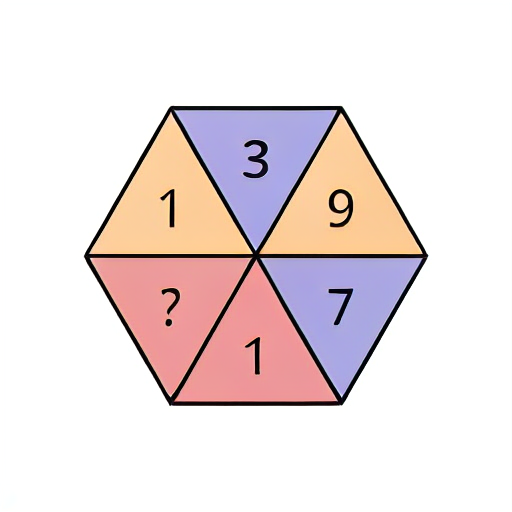

What is the missing number of the part denoted with a question mark?

# Options:
(A) 4
(B) 9
(C) 2
(D) 1

# Pattern:
There is a hexagon split into six parts with the colors ['purple', 'red', 'orange', 'purple', 'orange', 'red'] in an anti-clockwise order. The parts are denoted with the numbers [3, 1, '?', 1, 9, 7] respectively. We observe that the numbers in the orange parts add up to 10. Similarly, the numbers in the purple parts also add up to 10. Thus, the pattern is that the numbers in the parts of the same color add up to 10.

# Option A
Replacing '?' with 4: 


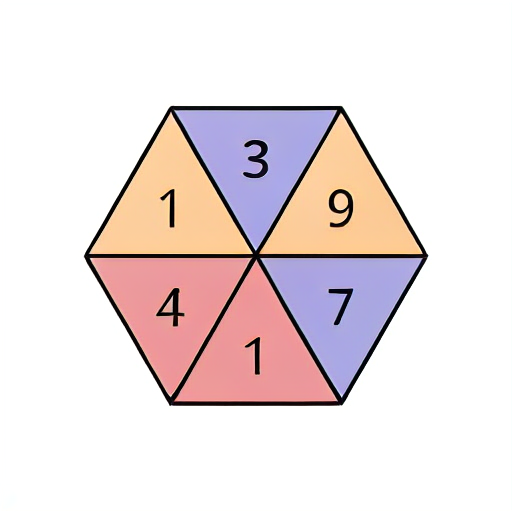


Reasoning: Comparing the sum of the numbers of the parts with the same color, it does not fit the observed pattern. 4 is unlikely to be the correct answer.

# Option B
Replacing '?' with 9: 


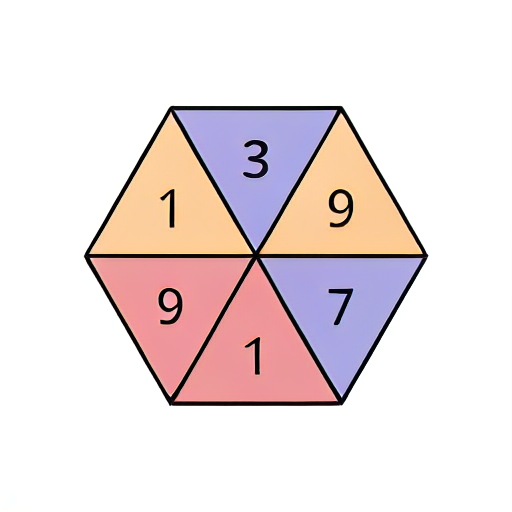


Reasoning: Comparing the sum of the numbers of the parts with the same color, it does not fit the observed pattern. 9 is unlikely to be the correct answer.

# Option C
Replacing '?' with 2: 


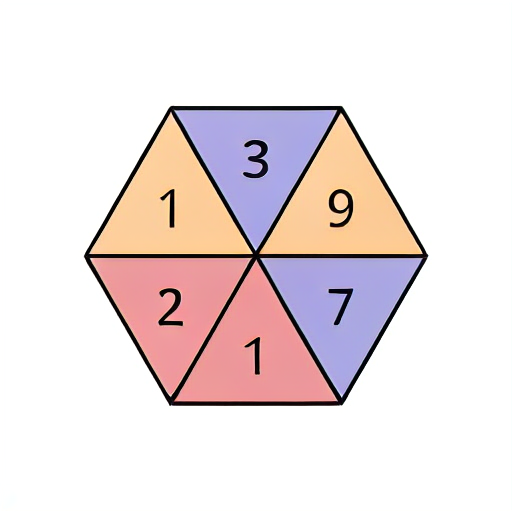


Reasoning: Comparing the sum of the numbers of the parts with the same color, it matches well the observed pattern. 2 is a strong candidate for the correct answer.

# Option D
Replacing '?' with 1: 


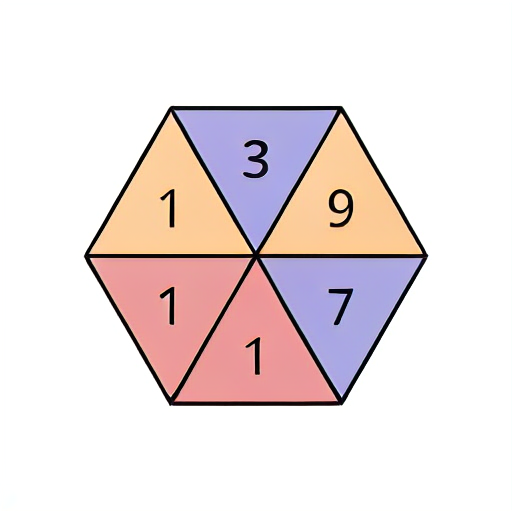


Reasoning: Comparing the sum of the numbers of the parts with the same color, it does not fit the observed pattern. 1 is unlikely to be the correct answer.

# Final Answer:
Based on the reasoning process, the best fit for the missing number is 2. The pattern that the numbers in the parts of the same color add up to 10, holds consistently when we replace '?' with 2. Therefore, among (A) (B) (C) (D), the answer is: (C).


In [26]:
from PIL import Image

# decode
for seg_id, (seg_type, seg_tokens) in enumerate(segments):
    if seg_type == "image_seg":
        assert seg_tokens.shape[1] == 1024
        img: Image = token_manager.decode_image(seg_tokens)[0]
        img.show()
    else:
        assert seg_type == "text_seg"
        decoded_text = token_manager.decode_text(seg_tokens)[0]
        print(decoded_text)

In [27]:
extract_final_answer(decoded_text)

'C'

# Attention

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
model_path = "Anole-7B-5DS-CE/final"

model = ChameleonForCausalLM.from_pretrained(
    ANOLE_PATH_HF,
    # ANOLE_PATH_HF_TRAINED / model_path,
    torch_dtype=torch.bfloat16,
    attn_implementation="eager"
).to(device).eval()

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.97s/it]


In [5]:
pattern_names = ['color_number_hexagon']

for pattern_name in pattern_names:
    eval_dataset = TokenizedDataset(
        data_dir=os.path.join(DATASET_TOKENIZED_DIR, "eval"),
        pattern_names=[pattern_name]
    )

    eval_dataloader = DataLoader(
        dataset=eval_dataset,
        batch_size=1,
        collate_fn=collate_fn,
        shuffle=False
    )
    break

for item in eval_dataloader:
    break

In [6]:
item['input_ids'].shape

torch.Size([1, 1079])

In [7]:
# !pip install quanto

In [ ]:
with torch.no_grad():
    outputs = model.generate(
        input_ids=item['input_ids'].to(device),
        attention_mask=item['attention_mask'].to(device),
        max_length=6144,
        do_sample=False,
        pad_token_id=1,
        output_attentions=True,
        return_dict_in_generate=True,
        # cache_implementation="offloaded",
        cache_implementation="quantized",
        cache_config={"nbits": 4, "backend": "quanto"},
    )
print(item['input_ids'].shape)
print(outputs.sequences.shape)

# Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.
attentions = outputs.attentions # num_new_sequences x (num_layers x (batch_size, num_heads, generated_length, sequence_length))
len(attentions), attentions[-1][0].shape

In [7]:
boi, eoi = 8197, 8196

boi_ids = (outputs.sequences[0]==boi).nonzero().cpu().numpy()
eoi_ids = (outputs.sequences[0]==eoi).nonzero().cpu().numpy()

In [8]:
from tqdm import tqdm
import numpy as np

def process_attn(attentions, seq_ids):
    attention_maps_dict = {}
    
    for seq_id in tqdm(seq_ids):
        # Step 1: Find the best head by examining each layer separately
        num_layers = len(attentions[seq_id])
        layer_attn_sample = attentions[seq_id][0]
        num_heads = layer_attn_sample.shape[1]
        
        head_scores = torch.zeros(num_heads, device='cpu')
        
        # Process each layer one at a time to score heads
        for layer_idx in range(num_layers):
            layer_attn = attentions[seq_id][layer_idx]  # Shape: [batch_size, num_heads, gen_len, seq_len]
            
            # Process each head separately to avoid large tensors in memory
            for head_idx in range(num_heads):
                head_attn = layer_attn[:, head_idx]
                head_score = head_attn.mean().item()  # Single scalar value
                head_scores[head_idx] += head_score
            
            # Clear memory
            del layer_attn
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Find best head
        best_head_idx = head_scores.argmax().item()
        
        # Step 2: Process only the best head from each layer
        sum_attention = None
        
        for layer_idx in range(num_layers):
            layer_attn = attentions[seq_id][layer_idx]  # Shape: [batch_size, num_heads, gen_len, seq_len]
            best_head_attn = layer_attn[:, best_head_idx].detach().cpu().float()
            
            if sum_attention is None:
                sum_attention = best_head_attn
            else:
                sum_attention += best_head_attn
            
            # Clear memory
            del layer_attn, best_head_attn
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Average across layers
        avg_attention = sum_attention / num_layers
        avg_attention = avg_attention.squeeze()
        
        # Store as a dictionary with sequence ID as key
        attention_maps_dict[seq_id] = {
            'attention': avg_attention.numpy(),
            'shape': avg_attention.shape
        }
        
        # Clear memory
        del sum_attention, avg_attention
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return attention_maps_dict

attention_maps_dict = process_attn(attentions, seq_ids=range(100, 969, 100))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 16.92it/s]


In [9]:
attention_maps_dict[100]

{'attention': array([0.01562905, 0.00558824, 0.00037195, ..., 0.028055  , 0.12098352,
        0.09195436], dtype=float32),
 'shape': torch.Size([1179])}

In [10]:
def combine_attention_maps(attention_maps_dict):
    # Find the maximum sequence length
    max_seq_length = max(data['shape'][-1] for data in attention_maps_dict.values())
    
    # Create padded results
    results = []
    seq_ids = []
    
    for seq_id, data in attention_maps_dict.items():
        attn_map = data['attention']
        current_seq_length = attn_map.shape[-1]
        
        # Pad if necessary
        if current_seq_length < max_seq_length:
            padding = np.zeros((max_seq_length - current_seq_length))
            padded_attn = np.hstack([attn_map, padding])
            results.append(padded_attn)
        else:
            results.append(attn_map)
        
        seq_ids.append(seq_id)
    
    return np.stack(results), seq_ids

attention_map, seq_ids = combine_attention_maps(attention_maps_dict)

In [11]:
attention_map.shape

(9, 1979)

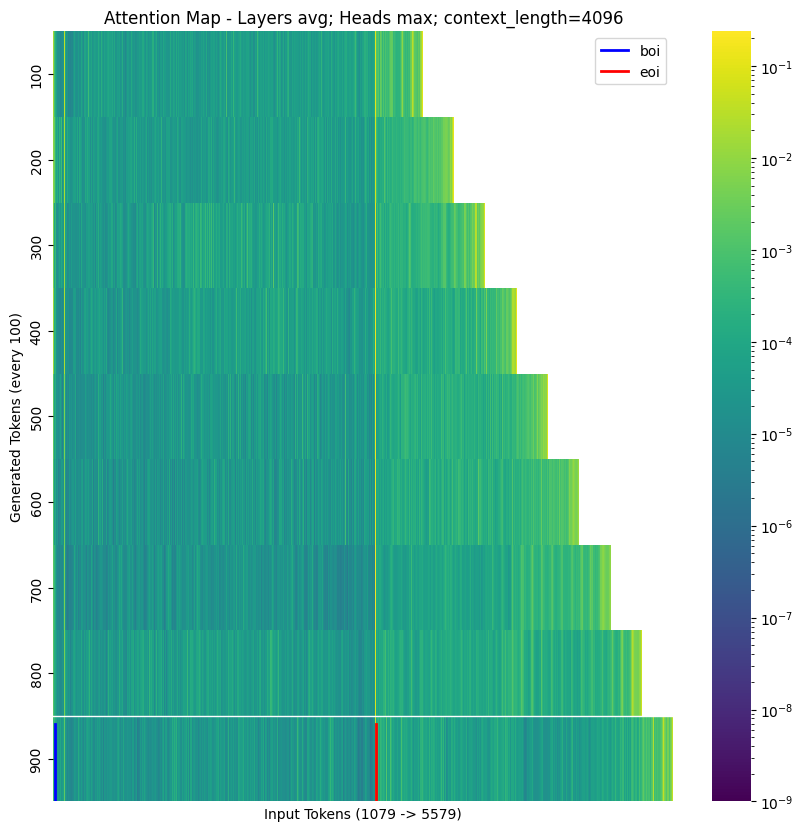

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Plot heatmap
plt.figure(figsize=(10, 10))

sns.heatmap(
    attention_map,
    xticklabels=[],
    yticklabels=seq_ids,
    cmap="viridis",
    norm=LogNorm(vmin=attention_map.min()+1e-9, vmax=attention_map.max())
)

# closest_idx = min(range(len(seq_ids)), key=lambda i: abs(seq_ids[i] - (4096 - 1079)))
# plt.axhline(y=closest_idx, color='white', linestyle='-', linewidth=1)
# plt.axvline(x=4048, color='white', linestyle='-', linewidth=1)

for idx, (boi_id, eoi_id) in enumerate(zip(boi_ids, eoi_ids)):
    if idx == 0:
        plt.axvline(x=boi_id, ymin=0, ymax=0.1, color='blue', linestyle='-', linewidth=2, label='boi')
        plt.axvline(x=eoi_id, ymin=0, ymax=0.1, color='red', linestyle='-', linewidth=2, label='eoi')
    else:
        plt.axvline(x=boi_id, ymin=0, ymax=0.1, color='blue', linestyle='-', linewidth=2)
        plt.axvline(x=eoi_id, ymin=0, ymax=0.1, color='red', linestyle='-', linewidth=2)

plt.title(f"Attention Map - Layers avg; Heads max; context_length=4096")
plt.xlabel("Input Tokens (1079 -> 5579)")
plt.ylabel("Generated Tokens (every 100)")
plt.legend()

plt.show()